### WIP Time-Series w/ Prophet

Q: What do We want to predict?

A: We want to predict the number of reviews

In [1]:
#install
!pip install prophet

In [2]:
# imports
import prophet
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# read the data
# Initialize an empty DataFrame to store the data
reviews = pd.DataFrame()

# Define the file path
file_path = '/gdrive/My Drive/ADC/yelp_project/datasets/yelp_academic_dataset_review.json'

# Specify the chunk size
chunksize = 100000

# Read the file in chunks and concatenate them
for chunk in pd.read_json(file_path, lines=True, chunksize=chunksize):
    reviews = pd.concat([reviews, chunk])

# Now, 'reviews' contains the entire dataset

In [5]:
# show the data
reviews.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [6]:
# read business data
business = pd.read_json('/gdrive/My Drive/ADC/yelp_project/datasets/yelp_academic_dataset_business.json', lines=True)

In [7]:
# show business data
business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
6,n_0UpQx1hsNbnPUSlodU8w,Famous Footwear,"8522 Eager Road, Dierbergs Brentwood Point",Brentwood,MO,63144,38.627695,-90.340465,2.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Sporting Goods, Fashion, Shoe Stores, Shopping...","{'Monday': '0:0-0:0', 'Tuesday': '10:0-18:0', ..."
7,qkRM_2X51Yqxk3btlwAQIg,Temple Beth-El,400 Pasadena Ave S,St. Petersburg,FL,33707,27.766590,-82.732983,3.5,5,1,None,"Synagogues, Religious Organizations","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


In [8]:
# join the files using business id
reviws_business = pd.merge(business, reviews, on='business_id')

In [9]:
# show the new data
reviws_business.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,9vwYDBVI3ymdqcyJ5WW2Tg,e0imecnX_9MtLnS2rUZM-A,5,3,2,1,I've had acupuncture treatments with Abby over...,2012-05-02 18:07:38
1,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,OXgg1LdxHDv3CBU5-xi2lA,_Q0fdLVoTnlNkEypUvNkHA,5,1,0,0,Abby is an amazing practitioner. In a treatmen...,2013-03-01 06:11:05
2,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,DG64cjud9cWB4fANskVxSw,ycUooVIDWPgXPf6niW-FWQ,4,2,0,0,I went to see Abby for some digestive issues. ...,2013-01-17 00:05:43
3,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,hzvRRb40oPttxAdyr7kfow,CiwVvb7jWijWB5jkmatzKA,5,0,1,0,"Abby helped me with some longstanding issues, ...",2015-03-16 03:43:08
4,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,xUkBPk-QfcW4i3MRU5TeXw,QkCbMKBktkrkOFJugHvY6w,5,0,0,0,"Recently, I referred a patient of mine with mu...",2013-03-05 18:45:07
5,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,7zGoOrFQT5WylJYax1pYnA,ZCACyKwpELPtwV4Hue5pcg,5,1,0,0,Abby Rappoport helped me achieve a long lost s...,2012-08-09 20:43:27
6,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,...,"Doctors, Traditional Chinese Medicine, Naturop...",None,2DhY5MYiQ8oy-ZqZthYiOg,q-RkAwuq6h6unalI2CWF0Q,5,2,0,0,Abby is an absolutely amazing acupuncturist.. ...,2012-05-04 03:47:09
7,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",-WXMS4p3D9NQsAPw4YPEyw,Jks_uMtTZHqP-84wSZ3COg,5,0,0,0,I have a po box there and ea. visit I am greet...,2014-09-15 14:37:42
8,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",z7TqAKXXArEB6LH6Nfr9BQ,trf3Qcz8qvCDKXiTgjUcEg,3,1,0,1,"Bottom Line: \nClean store, Quick Service, Go...",2011-08-01 03:45:56
9,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,...,"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ...",8Di0vZGcRLVNCZ-AWKgshA,auE6cx-AMcv2fv4SW_gnzA,5,0,0,0,I went in to ship a package to my friend for h...,2018-03-06 03:17:02


In [10]:
# filter the data to only contain Tucson city data and restaurants
#tucson_data = reviws_business.loc[reviws_business['city'] == 'Tucson' & reviws_business['categories'] == 'Restaurant']

tucson_data = reviws_business[reviws_business['categories'].str.contains('Restaurant', case=False) & (reviws_business['city'] == 'Tucson')]


In [11]:
# show the new Tucson data
tucson_data.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,...,categories,hours,review_id,user_id,stars_y,useful,funny,cool,text,date
2066,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Q8k6bndVPPDAQl9KuU9POA,1HUAEUkVOLZ5DptFf7oIvQ,2,1,0,0,Food used to great years ago but getting reall...,2016-02-23 18:05:34
2067,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",vKQdw2cgHsdxlwyZUDu-WA,PiRmHf4zfgo-etVA2-dUJg,4,0,0,0,I really enjoyed my BBQ pork chow mein. The se...,2017-07-19 22:09:13
2068,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4LuT9_uKT--jfsPPAYvXng,8LRqff_u-lHYjeg9sIDcUQ,4,0,0,0,I called in an order for pickup and for $30 go...,2017-11-08 07:48:23
2069,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",VAJn5Wl41yAwgMXPcGSHlA,Kyw24zTGZ6RkSTZos8zh_A,1,0,0,0,Waitress was rude when explaining that somethi...,2017-03-16 22:07:20
2070,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",jYUhqcQ4T_bC9g7dkZmS6Q,b_zVJ9n6qiUpGZGM2L4qVg,5,0,0,0,Love this place! I have been going here since ...,2011-05-02 21:04:11
2071,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",SKY_UwT57c7x2_XwLLkB7g,E4QsPSgniD2oFm3xI5K3sg,1,1,0,1,Food was very good until I found a wasp in my ...,2017-04-10 02:58:07
2072,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",2Ux44iq9-wPb7dQcoZFA6A,4aDP4qxTFiC6D3zIeFTjhg,4,0,0,0,It's been our favorite Chinese restaurant for ...,2017-08-11 04:40:12
2073,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",gK8r0RWY2_0yF-_5rh998A,1HnXRi1qGx5cog4T2Yitfg,4,1,0,1,"El ""Dragon Chino"" o ""China Dragon"" es un peque...",2012-11-11 05:23:08
2074,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",Xx42zaXUP3_71k7bGHwxpA,bUsnloyxec8_C0myvMB2vg,3,1,0,0,not many chinese restaurants in area\nlove the...,2018-04-17 04:07:10
2075,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,...,"Restaurants, Chinese","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",4clZKuxpxBGjt81amNS5Ng,SRuKAMyjgc-NyCz6NHukXQ,5,0,0,0,Highly recommend this place for Chinese! Food ...,2016-06-26 02:58:22


In [12]:
# show the shape and sample to 500
print(tucson_data.shape)
tucson_sample = tucson_data.head(500)
print(tucson_sample.shape)

(249640, 22)
(500, 22)


In [13]:
# show the columns
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars_x', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'review_id', 'user_id', 'stars_y',
       'useful', 'funny', 'cool', 'text', 'date'],
      dtype='object')

In [14]:
# drop unnecessary columns
columns_to_drop = ['postal_code', 'latitude', 'longitude', 'is_open', 'hours', 'useful', 'funny', 'cool']

# Use the drop method to remove the specified columns
tucson_sample = tucson_sample.drop(columns=columns_to_drop)

In [15]:
# show columns again
tucson_sample.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'stars_x',
       'review_count', 'attributes', 'categories', 'review_id', 'user_id',
       'stars_y', 'text', 'date'],
      dtype='object')

In [16]:
# set the date to index
tucson_sample = tucson_sample.set_index('date')
tucson_sample.index = pd.to_datetime(tucson_sample.index)

In [17]:
# show the data
tucson_sample.head()

,business_id,name,address,city,state,stars_x,review_count,attributes,categories,review_id,user_id,stars_y,text
date,,,,,,,,,,,,,
2016-02-23 18:05:34,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,3.0,23,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese",Q8k6bndVPPDAQl9KuU9POA,1HUAEUkVOLZ5DptFf7oIvQ,2,Food used to great years ago but getting reall...
2017-07-19 22:09:13,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,3.0,23,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese",vKQdw2cgHsdxlwyZUDu-WA,PiRmHf4zfgo-etVA2-dUJg,4,I really enjoyed my BBQ pork chow mein. The se...
2017-11-08 07:48:23,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,3.0,23,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese",4LuT9_uKT--jfsPPAYvXng,8LRqff_u-lHYjeg9sIDcUQ,4,I called in an order for pickup and for $30 go...
2017-03-16 22:07:20,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,3.0,23,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese",VAJn5Wl41yAwgMXPcGSHlA,Kyw24zTGZ6RkSTZos8zh_A,1,Waitress was rude when explaining that somethi...
2011-05-02 21:04:11,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,3.0,23,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","Restaurants, Chinese",jYUhqcQ4T_bC9g7dkZmS6Q,b_zVJ9n6qiUpGZGM2L4qVg,5,Love this place! I have been going here since ...


### Time-Series with Prophet

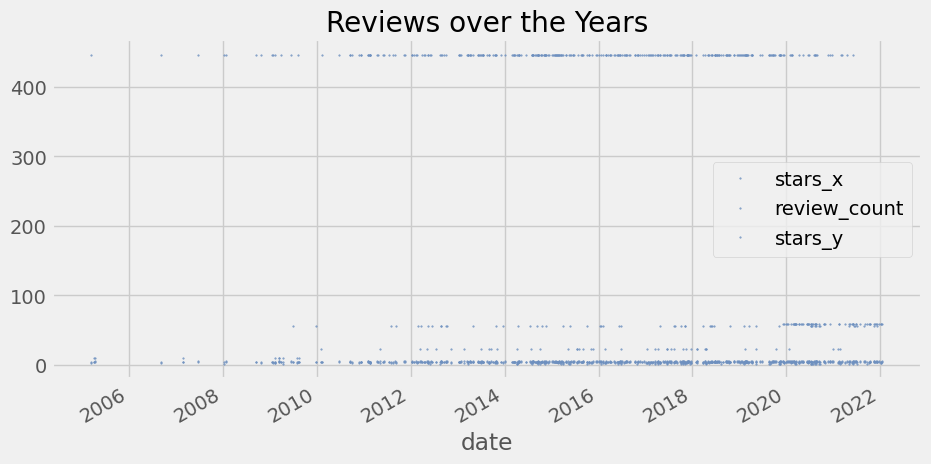

In [18]:
# plot the data
color_pal = sns.color_palette('vlag')
tucson_sample.plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Reviews over the Years')
plt.show()

In [19]:
# creating features to separate the data into days, month, year, season, etc.
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(tucson_sample, label='review_count')
features_and_target = pd.concat([X, y], axis=1)

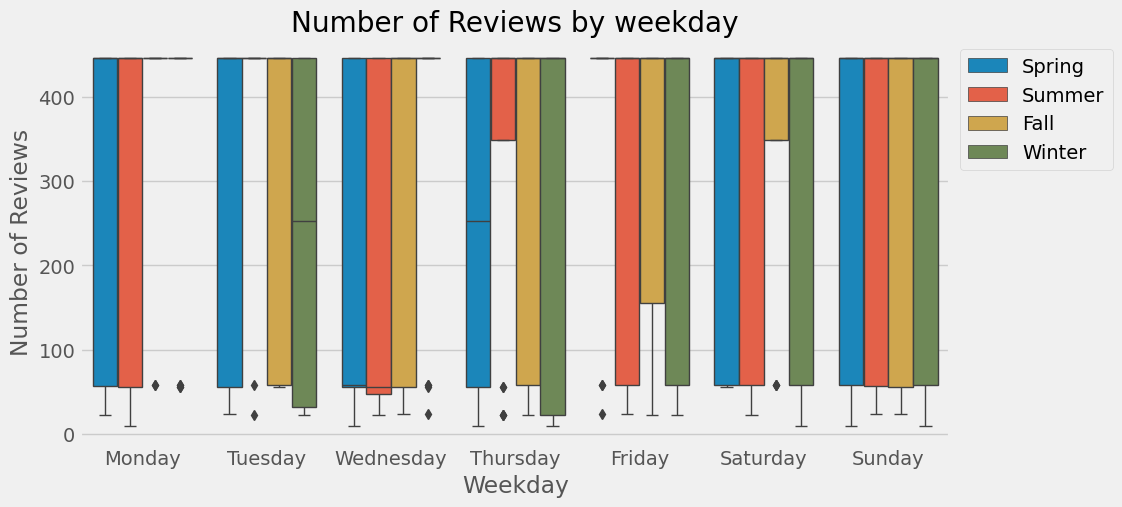

In [20]:
# plot data by season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='review_count',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Number of Reviews by weekday')
ax.set_xlabel('Weekday')
ax.set_ylabel('Number of Reviews')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

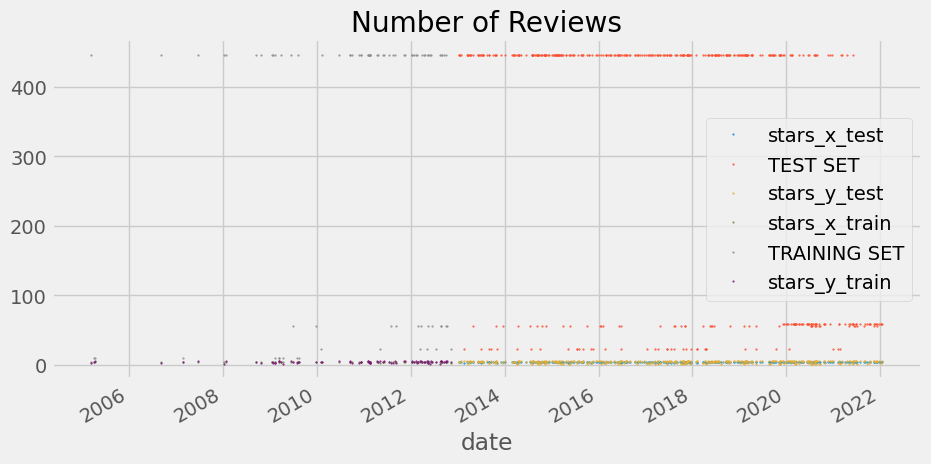

In [21]:
# starting with ml pipeline

split_date = '1-Jan-2013'
tucson_train = tucson_sample.loc[tucson_sample.index <= split_date].copy()
tucson_test = tucson_sample.loc[tucson_sample.index > split_date].copy()

# add suffixes to the columns
tucson_train = tucson_train.add_suffix('_train')
tucson_test = tucson_test.add_suffix('_test')

# plot train and test
tucson_test \
    .rename(columns={'review_count_test': 'TEST SET'}) \
    .join(tucson_train.rename(columns={'review_count_train': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Number of Reviews', style='.', ms=1)
plt.show()

In [33]:
# format data for prophet model using ds and y: ds should be our datetime data, and y should be our target data
tucson_train_prophet = tucson_train.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_train':'y'})
tucson_train_prophet.columns

Index(['ds', 'business_id_train', 'name_train', 'address_train', 'city_train',
       'state_train', 'stars_x_train', 'y', 'attributes_train',
       'categories_train', 'review_id_train', 'user_id_train', 'stars_y_train',
       'text_train'],
      dtype='object')

In [34]:
# creating the prophet model using default features
from prophet import Prophet

model = Prophet()
model.fit(tucson_train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsst13q5t/kpr6vwqb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsst13q5t/2nu51f75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77215', 'data', 'file=/tmp/tmpsst13q5t/kpr6vwqb.json', 'init=/tmp/tmpsst13q5t/2nu51f75.json', 'output', 'file=/tmp/tmpsst13q5t/prophet_model4j54npg0/prophet_model-20231005111505.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
11:15:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:15:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
# after training the model, we can run the 'predict' command
# predict on test set
tucson_test_prophet = tucson_test.reset_index() \
    .rename(columns={'date':'ds',
                     'review_count_test':'y'})

tucson_test_frcst = model.predict(tucson_test_prophet)

In [36]:
# show the new dataframe
tucson_test_frcst.head() #yhat (last column) represents the predictive value(s)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-09 12:23:17,330.753469,-7.049236,378.088890,330.753469,330.753469,-137.815764,-137.815764,-137.815764,-258.635129,...,-73.886677,-73.886677,-73.886677,194.706042,194.706042,194.706042,0.0,0.0,0.0,192.937704
1,2013-01-12 18:45:39,330.898854,221.730390,618.857213,330.898854,330.898854,97.533118,97.533118,97.533118,-88.130792,...,-6.684895,-6.684895,-6.684895,192.348805,192.348805,192.348805,0.0,0.0,0.0,428.431973
2,2013-01-14 20:49:57,330.991740,324.610032,701.286242,330.991740,330.991740,175.790515,175.790515,175.790515,18.578762,...,-19.668179,-19.668179,-19.668179,176.879932,176.879932,176.879932,0.0,0.0,0.0,506.782255
3,2013-01-28 02:55:30,331.581818,144.348541,518.335138,331.581818,331.581818,-1.381339,-1.381339,-1.381339,27.551631,...,-89.009859,-89.009859,-89.009859,60.076889,60.076889,60.076889,0.0,0.0,0.0,330.200479
4,2013-02-20 23:08:11,332.643300,-14.862840,370.560341,332.643300,332.643300,-157.187852,-157.187852,-157.187852,-2.882918,...,-134.009113,-134.009113,-134.009113,-20.295821,-20.295821,-20.295821,0.0,0.0,0.0,175.455447


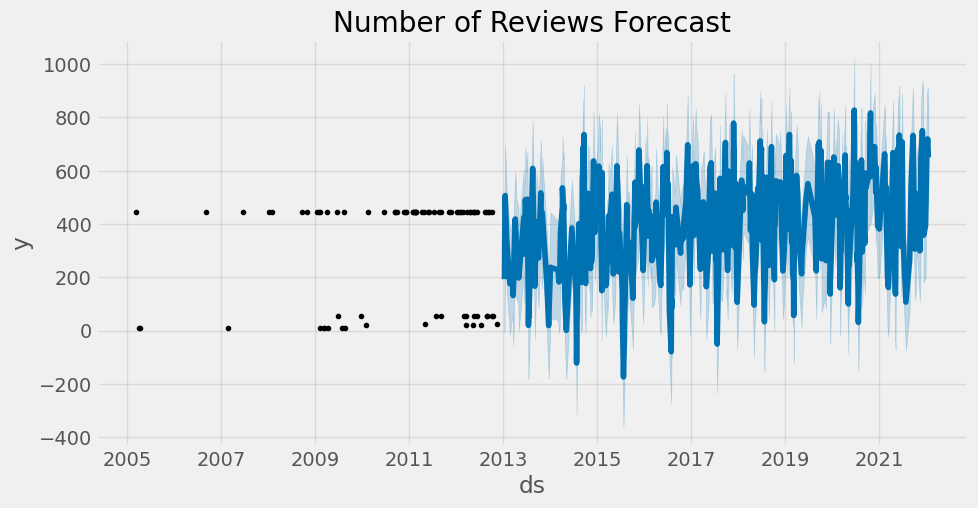

In [37]:
# plot the forecasted values
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(tucson_test_frcst, ax=ax)
ax.set_title('Number of Reviews Forecast')
plt.show() #y represents the target (number of reviews) and ds represents the date, which in this case is in years
# along with the predictions (in dark blue), we also have confidence intervals (in lighter blue)

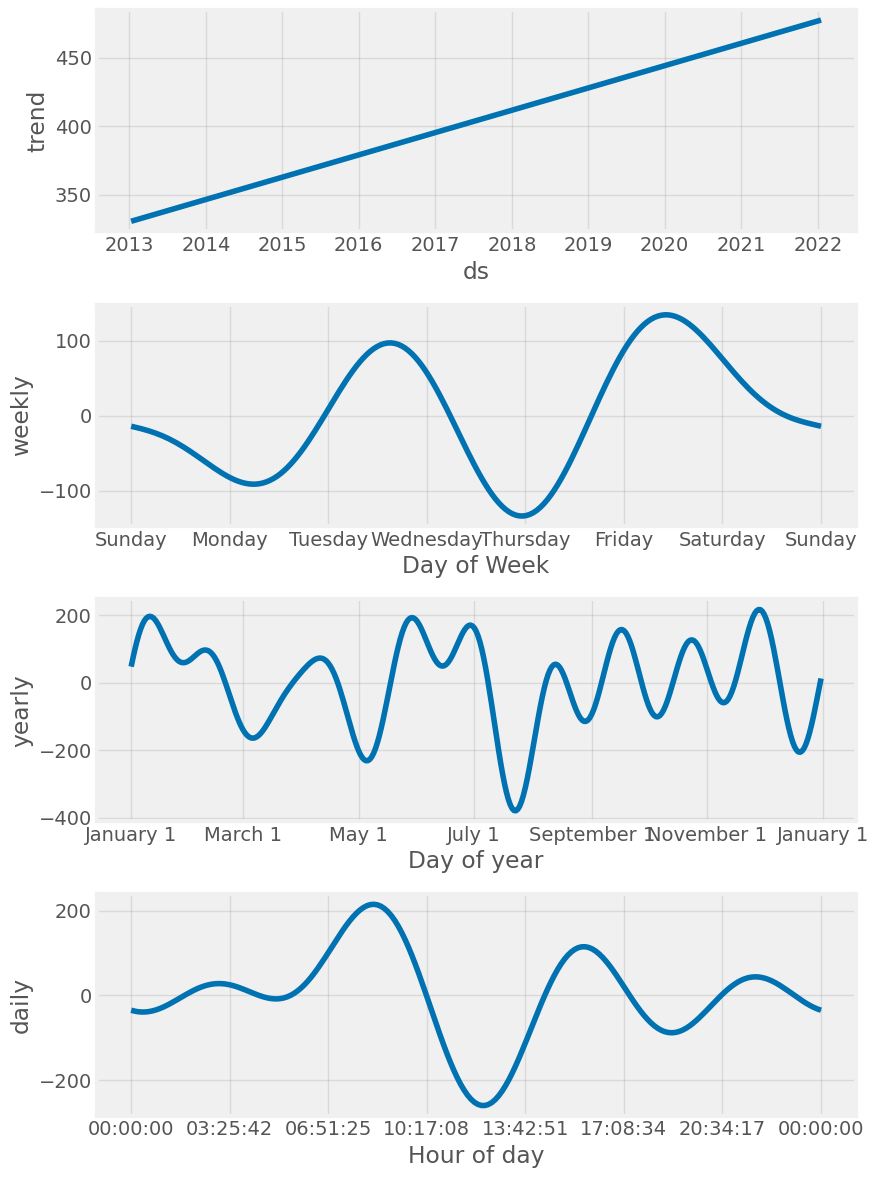

In [38]:
# lets plot the different prophet components of the data frame
fig = model.plot_components(tucson_test_frcst)
plt.show() # trend | weekly | yearly | daily
# the model combined these components to create the forecast above

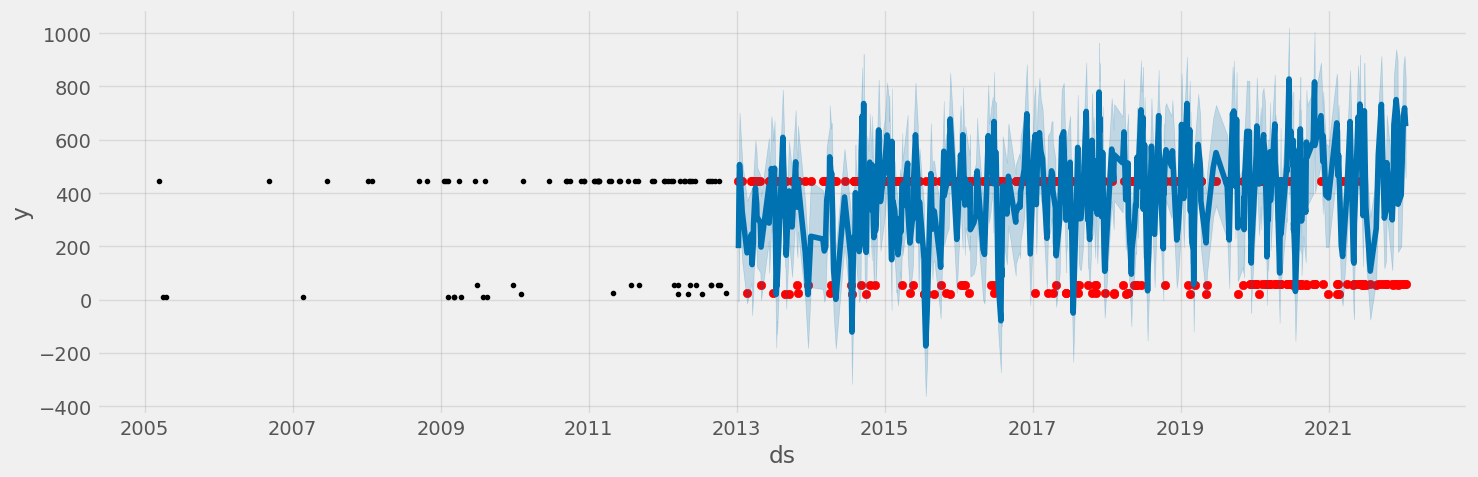

In [40]:
# evaluate the model
# let's compare the forecast with the actual number of reviews for each year
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)
# red-> actual values | blue-> predicted values | it looks like prophet picked up an upward trend

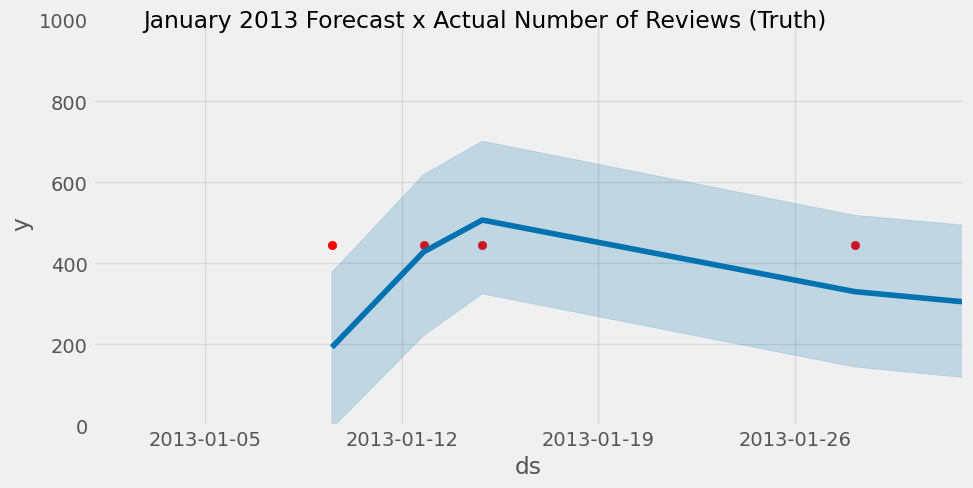

In [47]:
# now let's look at a more narrow time window-> starting with the first month year of our prediction, which is january 2013
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2013-01-01', '%Y-%m-%d')
upper_date = datetime.strptime('2013-02-01', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('January 2013 Forecast x Actual Number of Reviews (Truth)')

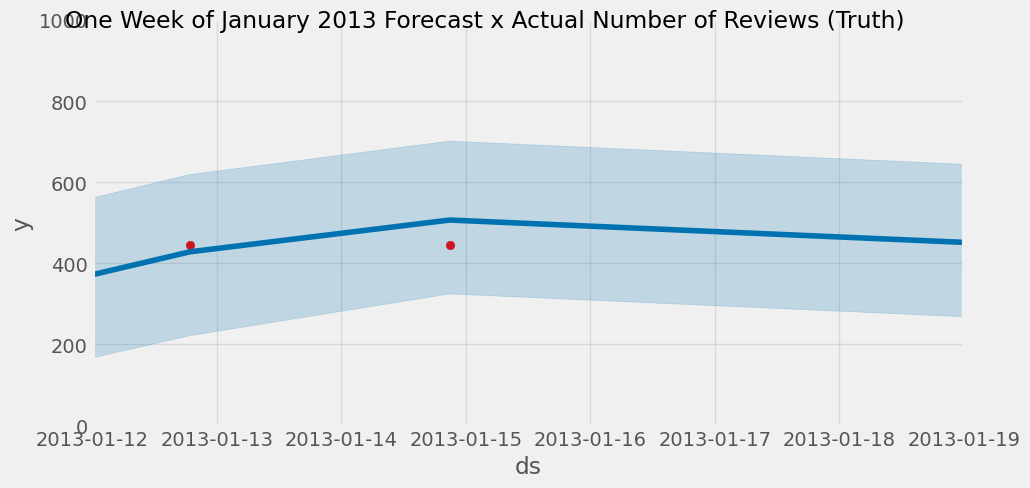

In [50]:
# now let's look at the one week! January 12th-19th 2013, since we can see above that the first two weeks don´t have reviews
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(tucson_test.index, tucson_test['review_count_test'], color='r')
fig = model.plot(tucson_test_frcst, ax=ax)

from datetime import datetime

lower_date = datetime.strptime('2013-01-12', '%Y-%m-%d')
upper_date = datetime.strptime('2013-01-19', '%Y-%m-%d')

ax.set_xbound(lower=lower_date, upper=upper_date)
ax.set_ylim(0, 1000)
plot = plt.suptitle('One Week of January 2013 Forecast x Actual Number of Reviews (Truth)')

In [51]:
# evaluate with error metrics